# Introduction to Data Science, Lab 2 (9/23)
- Processing data (+ Google Trends)
- Classification with Decision Trees, Random Forest, Boosting

## Presidential Elections 2016
We will model the results of 2016 deferal elections in each individual state based on the Google Trends data for search expressions of our choice. In this classification problem, the target variable $Y_i$ indicates if Trump received more popular votes than any other candidate in state $i$. The election results by state are contained in file *electoral_data.csv*, which we will need to process for our needs.  First, however, let's figure out how pyTrends work:

In [13]:
import pandas as pd
from pytrends.request import TrendReq

pt=TrendReq(hl='en-US',retries=10) # host language, retries.

# Google trends normalizes all trends data between 0 and 100 and accounts for
# the number of total searches at a given time and location. Google trends releases
# only relative interest magnitudes.

# Example:
search_words=["trump","clinton","pandemic"] # terms of interest
pt.build_payload(search_words,timeframe='2016-10-31 2016-11-07',geo='US') # temporal and spatial scope;
data=pt.interest_by_region(resolution='REGION') # 'REGION' flag will give the by-state statstics;
data.head(5)

,trump,clinton,pandemic
geoName,,,
Alabama,59,41,0
Alaska,65,35,0
Arizona,61,39,0
Arkansas,58,42,0
California,64,36,0


For each region (state) the sum is 100, distributed among search expressions. Is this what we need?

In [14]:
# We need to decide on:
#  - Search expressions whose trends to be used as regressors;
#  - Temporal scope of the fetched trends.

search_words=[["trump"],["clinton"],["taxes"],["immigration"],["james comey"],["gun"]]
scope='2016-10-31 2016-11-07'

### *Preparing the data*

In [15]:
# Let's look at the electoral data:
data=pd.read_csv('electoral_data.csv',header=1,sep=';',error_bad_lines=False)
data

,Unnamed: 0,Trump (R),Clinton (D),Trump (R).1,Clinton (D).1,All Others,Total Vote,Unnamed: 7
0,AL,9,NaN,1 318 255,729 547,75 570,2 123 372,AL
1,AK,3,NaN,163 387,116 454,38 767,318 608,AK
2,AZ,11,NaN,1 252 401,1 161 167,159 597,2 573 165,AZ
3,AR,6,NaN,684 872,380 494,65 310,1 130 676,AR
4,CA,NaN,55,4 483 814,8 753 792,943 998,14 181 604,CA
5,CO,NaN,9,1 202 484,1 338 870,238 893,2 780 247,CO
6,CT,NaN,7,673 215,897 572,74 133,1 644 920,CT
7,DE,NaN,3,185 127,235 603,23 084,443 814,DE
8,DC,NaN,3,12 723,282 830,15 715,311 268,DC
9,FL,29,NaN,4 617 886,4 504 975,297 178,9 420 039,FL


In [16]:
# Dropping extra columns and rows:
data.drop(data.columns[[1,2,-3,-2,-1]],axis=1,inplace=True)
data.drop(data.index[51:59],inplace=True)

# Rename columns:
new_columns=['state','trumpRes','clintonRes']
data.rename(columns={name:new_columns[i] for i,name in enumerate(data.columns)},inplace=True)

# Rename rows by states:
new_index={ind:data.loc[i,"state"] for i,ind in enumerate(data.index)}
data=data.rename(index=new_index)

# Remove states column:
data.drop("state",axis=1,inplace=True)
data.head(5)

,trumpRes,clintonRes
AL,1 318 255,729 547
AK,163 387,116 454
AZ,1 252 401,1 161 167
AR,684 872,380 494
CA,4 483 814,8 753 792


In [17]:
# Let's check there are no Nans:
data.isna().any()

trumpRes      False
clintonRes    False
dtype: bool

In [18]:
# There is one hidden problem:
display(data.loc[:,'trumpRes'].iloc[0:5]) # seems ok;
print(type(data.loc[:,'trumpRes'].iloc[0])) # entries are actually strings...
display(data.loc[:,'trumpRes'].iloc[0]) # '\xa0' is a code for non-breaking space.

AL    1 318 255
AK      163 387
AZ    1 252 401
AR      684 872
CA    4 483 814
Name: trumpRes, dtype: object

<class 'str'>


'1\xa0318\xa0255'

In [19]:
# Fix this:
data.loc[:,'trumpRes']=data.loc[:,'trumpRes'].apply(lambda x:  x.replace(u'\xa0','')).astype(int) # 'u' stands for unicode
data.loc[:,'clintonRes']=data.loc[:,'clintonRes'].apply(lambda x:  x.replace(u'\xa0','')).astype(int)

In [20]:
# Check:
print(type(data.loc[:,'trumpRes'].iloc[0]))

<class 'numpy.int64'>


In [21]:
# Add data from PyTrends:

for sw in search_words:
    pt.build_payload(sw,timeframe=scope,geo='US')
    data[sw]=pt.interest_by_region(resolution='REGION').values # values needed not to worry about index mismatch
data.head(5)

,trumpRes,clintonRes,trump,clinton,taxes,immigration,james comey,gun
AL,1318255,729547,68,73,49,53,26,81
AK,163387,116454,73,62,66,65,61,94
AZ,1252401,1161167,76,76,46,57,37,65
AR,684872,380494,70,78,55,60,37,82
CA,4483814,8753792,73,65,45,73,43,59


In [22]:
# Use this if PyTrends fail:

# data.to_csv('clean_data.csv')
# data=pd.read_csv('clean_data.csv',header=0,index_col=0)
# data

In [23]:
# Compute votes proportion:
data['trumpWinner']=data.loc[:,'trumpRes']>data.loc[:,'clintonRes'].astype(int)
data.head(5)

,trumpRes,clintonRes,trump,clinton,taxes,immigration,james comey,gun,trumpWinner
AL,1318255,729547,68,73,49,53,26,81,True
AK,163387,116454,73,62,66,65,61,94,True
AZ,1252401,1161167,76,76,46,57,37,65,True
AR,684872,380494,70,78,55,60,37,82,True
CA,4483814,8753792,73,65,45,73,43,59,False


In [24]:
# Drop more unnecessary columns but save "trumpRes" separately (for future):
trumpMargin=pd.Series(((data.loc[:,"trumpRes"]-data.loc[:,"clintonRes"])/(data.loc[:,"trumpRes"]+data.loc[:,"clintonRes"])).apply(lambda x: round(x,3)),index=data.index,name="trumpMargin")
data.drop(["trumpRes","clintonRes"],axis=1,inplace=True)

In [25]:
# Train/test split:
import numpy as np
train_ind=np.random.choice(range(len(data)),size=int(0.75*len(data)),replace=False)
test_ind=np.delete(np.arange(len(data)),train_ind)
train=data.iloc[train_ind]
test=data.iloc[test_ind]
print(f'Positive labels in train: {sum(train.loc[:,"trumpWinner"])} out of {len(train)} ({100*sum(train.loc[:,"trumpWinner"])/len(train):.0f}%)')
print(f'Positive labels in test: {sum(test.loc[:,"trumpWinner"])} out of {len(test)} ({100*sum(test.loc[:,"trumpWinner"])/len(test):.0f}%)')

Positive labels in train: 23 out of 38 (61%)
Positive labels in test: 7 out of 13 (54%)


Do we need to standardize features for Decision Trees?

### *Model 1: A single Decision Tree*
Decision Trees are non-parametric non-linear models for both classification and regression.

In [27]:
from sklearn.tree import DecisionTreeClassifier as DTC
model_1=DTC(criterion='entropy',min_samples_split=5)
model_1.fit(train.iloc[:,:-1],train.iloc[:,-1])

DecisionTreeClassifier(criterion='entropy', min_samples_split=5)

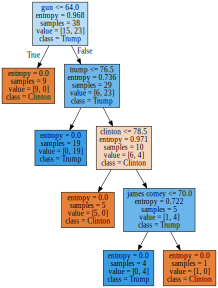

In [28]:
# Visualize the tree:
import graphviz
import pydotplus
from sklearn.tree import export_graphviz as export
dot_format=export(model_1,class_names=["Clinton","Trump"],filled=True,feature_names=train.columns[:-1])
pydot_graph=pydotplus.graph_from_dot_data(dot_format)
pydot_graph.set_size('"4,4!"')
graphviz.Source(pydot_graph.to_string())

In [29]:
# Let's color the nodes correctly (red for Trump and blue for Clinton).
# Object 'pydot_graph' has nodes as attributes, which are described as:
pydot_graph.get_node_list()[1].get_label()

'"gun <= 64.0\\nentropy = 0.968\\nsamples = 38\\nvalue = [15, 23]\\nclass = Trump"'

In [30]:
# Exercise: parse strings of this format to get the list of 'nvalues';
# Example: [17,21] should be the result of parsing the above string
# Hint: one built-in method from the last lab can be especially useful.

def parse(label):
    clinton=int(label.split('nvalue = [')[1].split(', ')[0])
    trump=int(label.split(']\\nclass')[0].split(', ')[1])
    return  [clinton,trump]

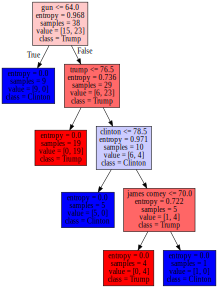

In [31]:
for node in pydot_graph.get_node_list():
    if node.get_label(): # the first node is 'None' 
        clinton,trump=parse(node.get_label())
        if clinton>trump:
            color='#{a:02x}{a:02x}ff'.format(a=int(2*255*trump/(trump+clinton)))
        else:
            color='#ff{a:02x}{a:02x}'.format(a=int(2*255*clinton/(trump+clinton)))
        node.set_fillcolor(color)
graphviz.Source(pydot_graph.to_string())

In [32]:
# Fetch predictions on the test set:

preds=model_1.predict(test.iloc[:,:-1])
results=[[int(p),int(t),int(not p^t)] for p,t in zip(preds,test.iloc[:,-1])]
results_df=pd.DataFrame(results,columns=['predicted','truth','correct?'],index=test.index)
display(results_df.T)

,IN,ME,MI,MO,MT,NV,NH,NJ,OR,PA,RI,SC,SD
predicted,1,1,1,1,1,0,0,0,0,1,0,1,1
truth,1,0,1,1,1,0,0,0,0,1,0,1,1
correct?,1,0,1,1,1,1,1,1,1,1,1,1,1


In [33]:
correct=np.sum([not p^t for p,t in zip(preds,test.iloc[:,-1])]) # ^ is logical xor
print(f'correct test predictions: {correct} out of {len(test)} ({100*correct/len(test):.0f}%)')

correct test predictions: 12 out of 13 (92%)


### *Feature Importance*
Internal nodes of Decision Trees always split based on a single feature and parallel to all other features. The split feature is chosen as to yield maximum reduction in the total weighted loss (e.g. entropy for classification and mean squared error for regression) after the split. Thus, it becomes possible to quantiy the roles (i.e importance) of each regressor by looking at the reduction in loss (if any) it brought across all splits in the tree. For example, this ranking procedure is realized as the "*feature_importances_*" attribute of a *DecisionTree* object in *scikit-learn*. Before fetching feature importance from our tree model, let's understand how exactly *scikit-learn* computes it.

Let $N$ be the set of all internal (non-leaf) nodes. For each $n\in N$, let $s_n$ be the number of samples inside it and $s_n^{(l)}$, $s_n^{(r)}$ be the counts of samples inside its left and right children, respectively. Similarly, let $c_n$ be the impurity of the node $n$ and $c_n^{(l)}$, $c_n^{(r)}$ be node impurities of its left and right children, respectively. Denote the set of nodes that split based on feature $f$ by $N_{f}$.  Then, the unnormalized importance score $M_f$ of feature $f$ is compted as 

$$M_f=\left(\sum_\limits{n\in N_f}s_nc_n-s_n^{(l)}c_n^{(l)}-s_n^{(r)}c_n^{(r)}\biggr/\sum_\limits{n\in N}s_nc_n-s_n^{(l)}c_n^{(l)}-s_n^{(r)}c_n^{(r)}\right).$$

The normalized score is then computed by dividing $M_f$ by the sum of importance scores across all features.

In [34]:
for sw,imp in zip(train.columns[:-1],model_1.feature_importances_):
    print(f'the importance score for "{sw}" is {imp:.4f}')

the importance score for "trump" is 0.3160
the importance score for "clinton" is 0.1659
the importance score for "taxes" is 0.0000
the importance score for "immigration" is 0.0000
the importance score for "james comey" is 0.0982
the importance score for "gun" is 0.4200


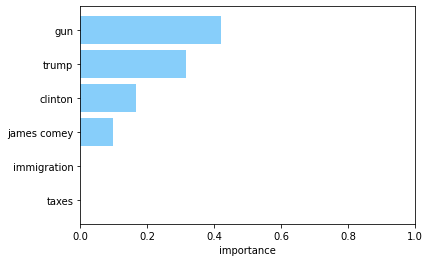

In [35]:
import matplotlib.pyplot as plt
plt.barh(range(len(train.columns[:-1])),sorted(model_1.feature_importances_),color="lightskyblue",align="center")
plt.yticks(range(len(train.columns[:-1])),train.columns[:-1][model_1.feature_importances_.argsort()])
plt.xlabel('importance')
plt.xlim((0,1))
plt.show()

### *Model 2: Random Forest*
Random Forest, as the name suggests, consists of fitting multiple decision trees on (randomly) different datasets and averaging their outputs at inference. This procedure is an instance of a subset of ensebling methods called "bagging" (bootstrap aggregating). In bagging, one creates $n$ datasets by randomly sampling (with replacement) from the actual "master" dataset and then fitting $n$ separate learners (e.g., trees), averaging them together during inference. Note that learners are indeed "separate" (with no interdepedence) and can train concurrently. In practice, this works better and more consistently compared to single-learner models by reducing variance of predictions. Moreover, with bagging, it is possible to estimate uncertainty of pedictions by computing their variance across all learners.

Random Forests is a classic example of baggig technique. However, in addition to the above procedure, each candidate split in any given learner is only possible on a feature from a randomly selected subset of features (of size $\sqrt{d}$ in *sklearn* by default) which is resampled after evaluation (i.e. not shared between candidate splits). This step encourages indiviudal learners to become different, hence increasing the variability across learners and making the resulting ensemble model more robust, on average.

In [36]:
from sklearn.ensemble import RandomForestClassifier as RFC
num_learners=200
model_2=RFC(n_estimators=num_learners,criterion='entropy',min_samples_split=5,bootstrap=True,max_features=None)
model_2.fit(train.iloc[:,:-1],train.iloc[:,-1])

RandomForestClassifier(criterion='entropy', max_features=None,
                       min_samples_split=5, n_estimators=200)

In [37]:
# We can extract individual trees:
print(f'we fitted {len(model_2.estimators_)} decision trees!')

we fitted 200 decision trees!


Let's visualize individual trees. Note that the class balance in the root node is different from tree to tree (because we set *bootstrap=True*, which makes train samples for each tree to be randomly sampled from our overall train data).

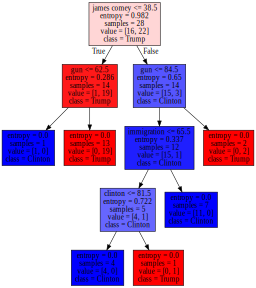

In [38]:
# Visualize trees one by one:
tree=model_2.estimators_[39] # change this!
dot_format=export(tree,class_names=["Clinton","Trump"],filled=True,feature_names=train.columns[:-1])
pydot_graph=pydotplus.graph_from_dot_data(dot_format)
pydot_graph.set_size('"4,4!"')
for node in pydot_graph.get_node_list():
    if node.get_label(): # the first node is 'None' 
        clinton,trump=parse(node.get_label())
        if clinton>trump:
            color='#{a:02x}{a:02x}ff'.format(a=int(2*255*trump/(trump+clinton)))
        else:
            color='#ff{a:02x}{a:02x}'.format(a=int(2*255*clinton/(trump+clinton)))
        node.set_fillcolor(color)
graphviz.Source(pydot_graph.to_string())

In [39]:
# Fetch predictions on the test set:

preds=model_2.predict(test.iloc[:,:-1])
results=[[int(p),int(t),int(not p^t)] for p,t in zip(preds,test.iloc[:,-1])]
results_df=pd.DataFrame(results,columns=['predicted','truth','correct?'],index=test.index)
display(results_df.T)

,IN,ME,MI,MO,MT,NV,NH,NJ,OR,PA,RI,SC,SD
predicted,1,1,1,1,1,1,0,0,0,1,0,1,1
truth,1,0,1,1,1,0,0,0,0,1,0,1,1
correct?,1,0,1,1,1,0,1,1,1,1,1,1,1


In [40]:
# Accuracy:
correct=np.sum([not p^t for p,t in zip(preds,test.iloc[:,-1])]) # ^ is logical xor
print(f'correct test predictions: {correct} out of {len(test)} ({100*correct/len(test):.0f}%)')

correct test predictions: 11 out of 13 (85%)


We have seen the computation of feature importance from a single decision tree. Can we generalize to random forests? What could be the simplest extension?

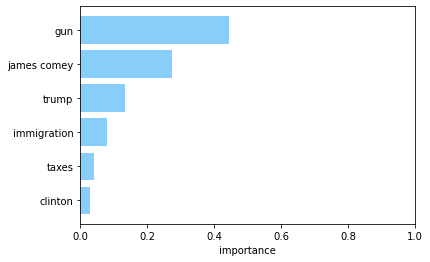

In [41]:
# Feature importance:
plt.barh(range(len(train.columns[:-1])),sorted(model_2.feature_importances_),color="lightskyblue",align="center")
plt.yticks(range(len(train.columns[:-1])),train.columns[:-1][model_2.feature_importances_.argsort()])
plt.xlabel('importance')
plt.xlim((0,1))
plt.show()

Let's estimate the uncertainty of the predictions on $x$ made by individual trees by one standard deviation: $\hat{\sigma}(x)=\sqrt{\frac{\sum_{i=1}^{B}\left(\hat{y_i}(x)-y(x)\right)^2}{B-1}}$, where $\hat{y_i}(x)$ is predicted class of input $x$, $y(x)$ is ground truth for $x$ and $B$ is the number of learners in our ensemple ($B=200$).

In [42]:
# Estimate uncertainty of predictions:
predictions=[]
for tree in model_2.estimators_:
    predictions.append(tree.predict(test.iloc[:,:-1]))

In [43]:
def uncertainty(x,y,y_hat):
    y_hat_x=[prediction[x] for prediction in y_hat]
    sigma_hat=np.sqrt(np.divide(sum([(p-y[x])**2 for p in y_hat_x]),num_learners))
    return sigma_hat
uncertainty(7,test.iloc[:,-1],predictions)

0.282842712474619

In [44]:
# Exercise: estimate uncertainty ("difficulty") of different test observations (states);
# In particular, create and display a pandas DataFrame showing uncertainty for each of 12 states.

difficulties=pd.DataFrame([round(uncertainty(obs,test.iloc[:,-1],predictions),3) for obs in range(len(test))],index=test.index,columns=["sigma_hat"])
display(difficulties.T)

,IN,ME,MI,MO,MT,NV,NH,NJ,OR,PA,RI,SC,SD
sigma_hat,0.2,0.758,0.534,0.173,0.636,0.903,0.361,0.283,0.464,0.675,0.274,0.212,0.141


Some states seem to be "easy" and correctly classified by nearly all trees; some others are remarkably hard. How can we get a better understanding of why some states are harder than others?

In [45]:
difficulties=difficulties.T
difficulties=difficulties.append(trumpMargin[test.index])
display(difficulties)

,IN,ME,MI,MO,MT,NV,NH,NJ,OR,PA,RI,SC,SD
sigma_hat,0.200,0.758,0.534,0.173,0.636,0.903,0.361,0.283,0.464,0.675,0.274,0.212,0.141
trumpMargin,0.202,-0.032,0.002,0.196,0.222,-0.026,-0.004,-0.146,-0.123,0.008,-0.166,0.149,0.319


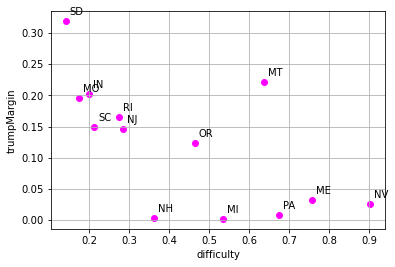

In [46]:
offset=0.01
plt.scatter(x=difficulties.loc["sigma_hat"],y=difficulties.loc["trumpMargin"].apply(lambda x: abs(x)),c='fuchsia')
for i,col in enumerate(difficulties.columns):
    plt.annotate(col,(difficulties.loc["sigma_hat"].iloc[i]+offset,abs(difficulties.loc["trumpMargin"].iloc[i])+offset))
plt.xlabel("difficulty")
plt.ylabel("trumpMargin")
plt.grid()
plt.show()

Can we make learners focus on "difficult" observations (states)?

### *Model 3: Gradient Tree Boosting*
Just as Random Forest is an example of bagging, Gradient Tree Boosting is an instance of yet another type of ensembling called Boosting. The philosophy behind these methods is to train multiple learners *in sequence* and focus each new learner on improving the *overall* performance of the current ensemble. Thus, in particular, each new learner must concentrate on most "difficult" examples (those that the current ensemble mispredicts) from the training data. In practice, this "focus" can be enforced in many forms either implicitly of explicitly. For example, one of the simplest approaches is to increase the weight of difficult training examples in the loss function of a new learner. Alternatively, the sampling probability of a training example could be linked to its current "difficulty", resulting in drawing troublesome data more often. Inference in boosting algorithms is weighted, i.e. predictions of different learners are not considered equally valuable.

Gradient Boosting shares the same ideology as described above, however, the "focus" on difficult examples in subsequent learners is enforced implicitly. New learners are fitted to (i.e. having as a target variable) the so-called *pseudo-residuals* of the current ensemble model (more on this in DS-GA 1003).

In [47]:
from sklearn.ensemble import GradientBoostingClassifier as GBC
model_3=GBC(n_estimators=200,min_samples_split=5,max_features=None)
model_3.fit(train.iloc[:,:-1],train.iloc[:,-1])

GradientBoostingClassifier(min_samples_split=5, n_estimators=200)

In [48]:
# Fetch predictions on the test set:

preds=model_3.predict(test.iloc[:,:-1])
results=[[int(p),int(t),int(not p^t)] for p,t in zip(preds,test.iloc[:,-1])]
results_df=pd.DataFrame(results,columns=['predicted','truth','correct?'],index=test.index)
display(results_df.T)

,IN,ME,MI,MO,MT,NV,NH,NJ,OR,PA,RI,SC,SD
predicted,1,1,1,1,0,1,0,0,0,1,0,1,1
truth,1,0,1,1,1,0,0,0,0,1,0,1,1
correct?,1,0,1,1,0,0,1,1,1,1,1,1,1


In [49]:
correct=np.sum([not p^t for p,t in zip(preds,test.iloc[:,-1])]) # ^ is logical xor
print(f'correct test predictions: {correct} out of {len(test)} ({100*correct/len(test):.0f}%)')

correct test predictions: 10 out of 13 (77%)
